In [1]:
import torch
from torchsummary import summary
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import seaborn as sns

from trainer import Trainer
from config import get_config
from utils import prepare_dirs, save_config, load_config
from data_loader import get_train_valid_loader, get_test_loader, get_embedding_test_loader

sns.despine(top=False, right=False)

def configure_embeddings(config):
    # create Omniglot data loaders
    torch.manual_seed(config.random_seed)
    kwargs = {}
    if config.use_gpu:
        torch.cuda.manual_seed(config.random_seed)
        kwargs = {'num_workers': 1, 'pin_memory': True}
    if config.is_train:
        data_loader = get_train_valid_loader(
            config.data_dir, config.batch_size,
            config.num_train, config.augment,
            config.way, config.valid_trials,
            config.shuffle, config.random_seed,
            **kwargs
        )
    else:
        if config.get_embedding:
            data_loader = get_embedding_test_loader(
                config.data_dir, config.n_embeddings,
                config.batch_size, config.random_seed,
                alphabet=config.alphabet, **kwargs
            )
        else:
            data_loader = get_test_loader(
                config.data_dir, config.way,
                config.test_trials, config.random_seed,
                **kwargs
            )

    # sample 3 layer wise hyperparams if first time training
    if config.is_train and not config.resume:
        print("[*] Sampling layer hyperparameters.")

        layer_hyperparams = {
            'layer_init_lrs': [],
            'layer_end_momentums': [],
            'layer_l2_regs': []
        }
        for i in range(6):
            # sample
            lr = random.uniform(1e-4, 1e-1)
            mom = random.uniform(0, 1)
            reg = random.uniform(0, 0.1)

            # store
            layer_hyperparams['layer_init_lrs'].append(lr)
            layer_hyperparams['layer_end_momentums'].append(mom)
            layer_hyperparams['layer_l2_regs'].append(reg)
        try:
            save_config(config, layer_hyperparams, override=False)
        except ValueError:
            print(
                "[!] Samples already exist. Either change the model number,",
                "or delete the json file and rerun.",
                sep=' '
            )
            raise
    # else load it from config file
    else:
        try:
            layer_hyperparams = load_config(config)
        except FileNotFoundError:
            print("[!] No previously saved config. Set resume to False.")
            raise
    return data_loader, layer_hyperparams

<Figure size 432x288 with 0 Axes>

# Load configuration

In [2]:
config, unparsed = get_config()


config.num_model = 2
config.batch_size = 1
config.is_train = False
config.get_embedding = True
config.use_gpu = False
config.data_dir = './data/evaluation/'

# ensure directories are setup
prepare_dirs(config)

In [3]:
config.print_values()

valid_trials : 320
test_trials : 400
way : 20
num_train : 90000
batch_size : 1
num_workers : 1
shuffle : True
augment : True
is_train : False
get_embedding : True
n_embeddings : 1000
alphabet : Mongolian
epochs : 200
init_momentum : 0.5
lr_patience : 1
train_patience : 20
flush : False
num_model : 2
use_gpu : False
best : True
random_seed : 1
data_dir : ./data/evaluation/
ckpt_dir : ./ckpt/
logs_dir : ./logs/
resume : False


# Alphabet: Avesta

In [4]:
config.alphabet = 'Avesta'
config.n_embeddings = 600
data_loader, layer_hyperparams = configure_embeddings(config)

trainer = Trainer(config, data_loader, layer_hyperparams)

images, embeddings, labels = trainer.get_embeddings()

[*] Loaded layer hyperparameters.
[*] Number of model parameters: 1,256,657
[*] Loading model from ./ckpt/exp_2
[*] Loaded best_model_ckpt.tar checkpoint @ epoch 73 with best valid acc of 90.000


C:\Users\bruno.silva\Desktop\g-01-oneshotimagerecognition\siamese_networks\model.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight, 0, 1e-2)
C:\Users\bruno.silva\Desktop\g-01-oneshotimagerecognition\siamese_networks\model.py:47: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.bias, 0.5, 1e-2)
C:\Users\bruno.silva\Desktop\g-01-oneshotimagerecognition\siamese_networks\model.py:49: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight, 0, 2e-1)
C:\Users\bruno.silva\Desktop\g-01-oneshotimagerecognition\siamese_networks\model.py:50: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.bias, 0, 1e-2)
C:\Users\bruno.silva\Desktop\g-01-oneshotimagerecognition\siamese_networks\trainer.py:319: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(x, vol

In [5]:
images.shape

(600, 1, 1, 105, 105)

In [46]:
embeddings.shape

(600, 1, 512)

In [47]:
labels.shape

(600, 1, 1)

In [112]:
def plot_embeddings(embedding_2d, labels, alphabet, title_complement=''):
    #markers = {0: "o", 1: "D"}
    #style = (labels.astype(int) % 2 == 0).astype(int)
    style = labels
    markers = {l: f'${l:.0f}$' for l in np.unique(labels)}
    fig, ax = plt.subplots(figsize=(7, 5))
    ax = sns.scatterplot(x=embedding_2d[:,0], y=embedding_2d[:,1], 
                         style=style, linewidth=0, hue=labels.astype(str),
                         markers=markers, legend=False, s=120)
    ax.set_title(alphabet + title_complement, size=14)
    
    plt.show()

images = images.reshape(config.n_embeddings, 105, 105)
embeddings = embeddings.reshape(config.n_embeddings, -1)
labels = labels.reshape(config.n_embeddings)

## Siamese Embedding

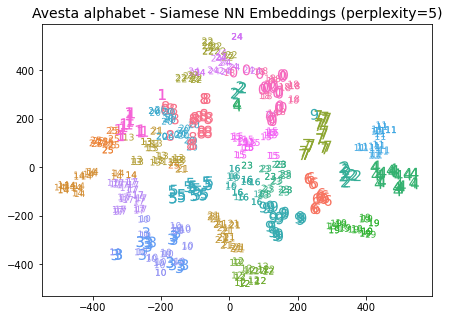

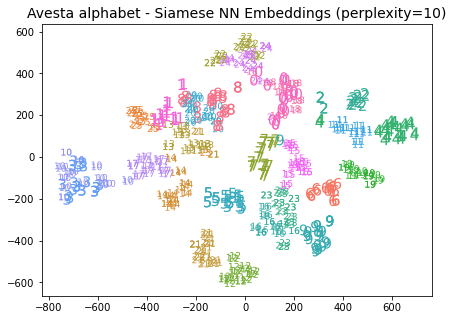

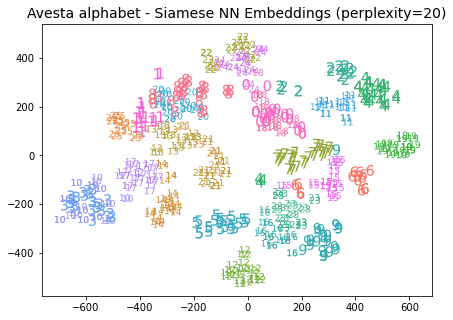

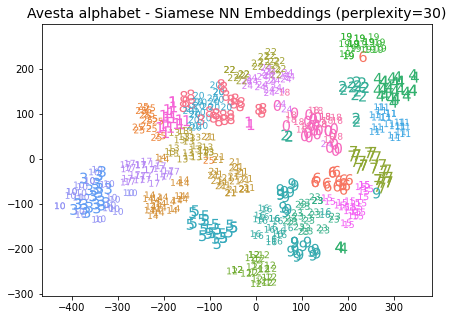

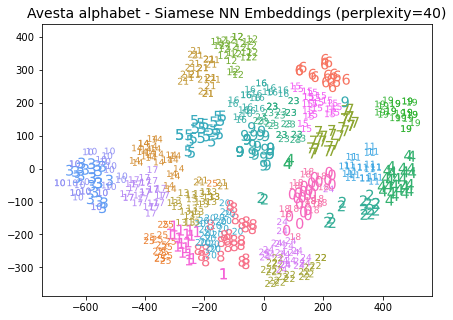

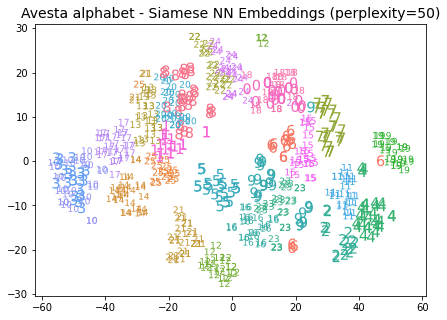

In [113]:
perplexity = [5, 10, 20, 30, 40, 50]

for p in perplexity:
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=p, n_iter=5000)
    embeddings_2d = tsne.fit_transform(embeddings)
    plot_embeddings(embeddings_2d, labels, config.alphabet, f' alphabet - Siamese NN Embeddings (perplexity={p})')

In [114]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=40, n_iter=5000)
embeddings_2d = tsne.fit_transform(embeddings)

In [115]:
tsne.n_iter_

4999

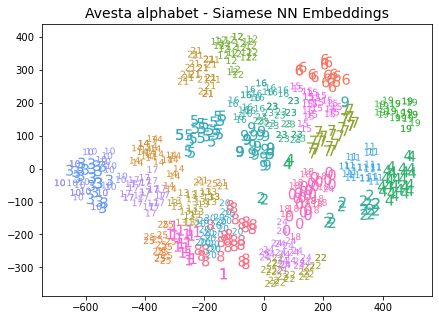

In [116]:
plot_embeddings(embeddings_2d, labels, config.alphabet, ' alphabet - Siamese NN Embeddings')

## Original Embedding

In [32]:
images.reshape(config.n_embeddings, -1).shape

(600, 11025)

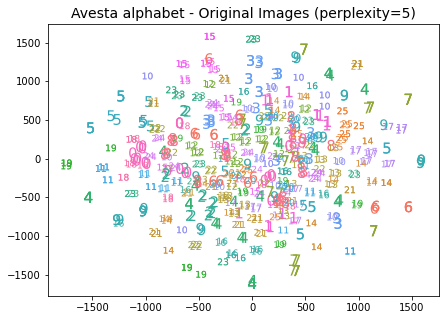

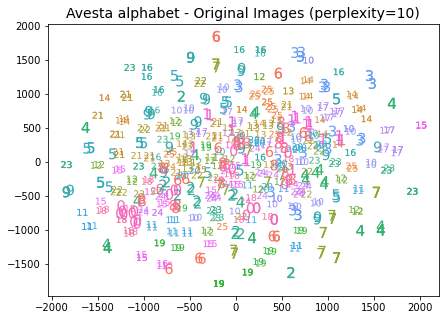

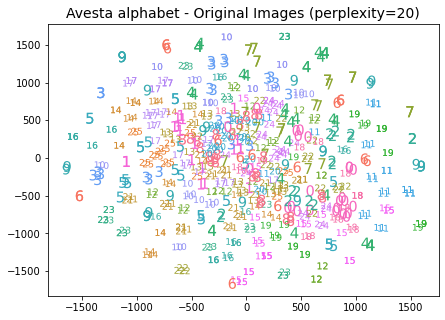

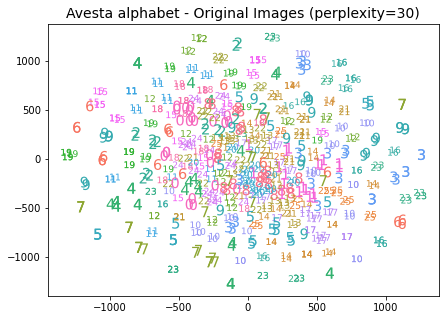

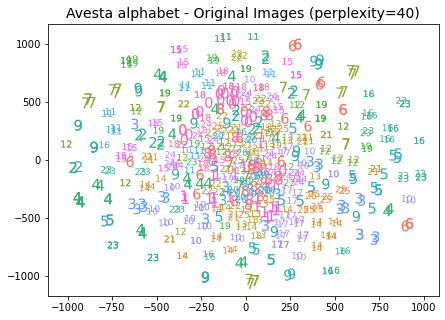

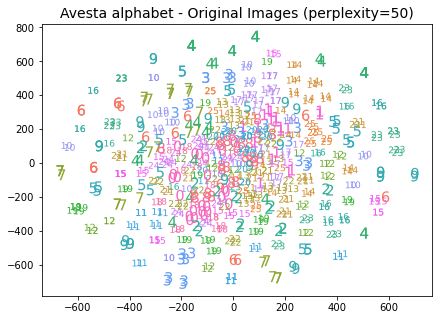

In [122]:
perplexity = [5, 10, 20, 30, 40, 50]

for p in perplexity:
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=p, n_iter=5000)
    embeddings_2d = tsne.fit_transform(images.reshape(config.n_embeddings, -1))
    plot_embeddings(embeddings_2d, labels, config.alphabet, f' alphabet - Original Images (perplexity={p})')

In [118]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=40, n_iter=5000)
embeddings_2d = tsne.fit_transform(images.reshape(config.n_embeddings, -1))

In [119]:
tsne.n_iter_

4999

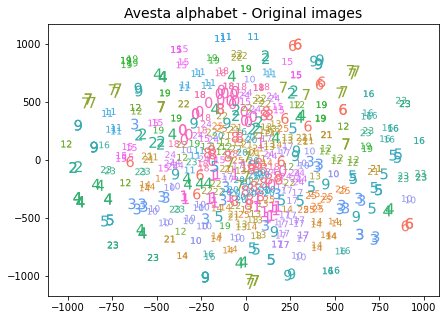

In [121]:
plot_embeddings(embeddings_2d, labels, config.alphabet, ' alphabet - Original images')